In [1]:
import pandas as pd
import numpy as np
from analytics.bamboo import Bamboo as bb
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr, ttest_ind,ttest_rel, f_oneway, mannwhitneyu,wilcoxon
import ast
import re
import math
import statsmodels.api as sm

warnings.filterwarnings('ignore')

### Load data

In [ ]:
"""
Can replace this section to 

df = pd.read_csv(filepath+'survey.csv') 

when published to github
"""

In [2]:
df = bb.query_presto(
    sql=r'''
    SELECT
        A.*,
        B.embedding_count,
        B.user_friend_diversity,
        B.friend_friend_count,
        B.friend_interaction_count,
        C.interact_edge,
        C.interact_count,
        C.friend_interact_edge,
        C.friend_interact_count as avg_friend_interact_count,
        C.user_friend_diversity as avg_friend_diversity
    FROM survey_user_motif:datascience A
    JOIN survey_user_friend_new:datascience B
        ON A.rid = B.rid
        AND A.ds = B.ds
    JOIN friend_diversity:datascience C
        ON A.rid = C.rid
        AND A.ds = C.ds
    ''',
    namespace='datascience',
)

Processed 307569 rows, Splits (completed|running|queued): 854|3135|0, Time (cpu|wall): 74578|129087 msec

I1112 103425.684 presto.py:114] https://internalfb.com/intern/presto/query/?query_id=20211112_183422_15988_byxbd


[===========================================================================] | rows:  85.5K | (2.7 min)



I1112 103718.340 presto.py:140] 85535 row(s) returned in 7578.2878 ms


In [3]:
df_region = bb.query_presto(
    sql=r'''
        SELECT
            *
        FROM country_to_region_map:ad_metrics
        
    ''',
    namespace='ad_metrics',
)

df = df.merge(df_region[['country','business_region']], on = 'country')

Processed 241 rows, Splits (completed|running|queued): 1|4|0, Time (cpu|wall): 13|70 msec

I1112 104152.634 presto.py:114] https://internalfb.com/intern/presto/query/?query_id=20211112_184152_94792_vsz2x


[===========================================================================] | rows:    241 | (0.1 sec)

I1112 104152.753 presto.py:140] 241 row(s) returned in 1172.8446 ms


### pre-processing and aggregating results for figures 
satisfaction:
- -1 -- fewer friends
- 0 -- same friends
-1 -- more friends

In [6]:
df['friend_bins'] = pd.cut(df['friend_count'], bins = np.linspace(0, 5000, 51))
df = df.merge(df.groupby('friend_bins')['rid'].count().reset_index().rename(columns = {'rid':'bin_sum'}), on = 'friend_bins')

df['friend_bins2'] = pd.cut(df['friend_count'], bins = np.linspace(0, 5000, 21))
df = df.merge(df.groupby('friend_bins2')['rid'].count().reset_index().rename(columns = {'rid':'bin_sum2'}), on = 'friend_bins2')

df['satisfaction'] =  df['friend_numeric'].apply(lambda x: -1 if x < 4 else 0 if x == 4 else 1 )

In [4]:
df['age'] = df['age'].astype(int)
df['gender_name'] = df['gender'].apply(lambda x: 'female' if x == '1'else 'male' if x == '2' else 'unknown')

In [7]:
df['age_group'] = df['age'].apply(lambda x: '<18' if x<18 else ('18-29' if x<30 else ('30-49' if x<50 else ('50-64' if x<65 else '>65'))))

### (Section 2.1) Basic stats of the surveyed users

Gender distribution

In [11]:
round(df.groupby(['gender_name','satisfaction']).count()['rid']/df.groupby(['gender_name']).count()['rid']*100,1)

gender_name  satisfaction
female       -1              10.1
              0              52.5
              1              37.4
male         -1               8.1
              0              35.6
              1              56.3
unknown      -1              13.1
              0              56.4
              1              30.6
Name: rid, dtype: float64

Region distribution

In [12]:
round(df.groupby(['business_region','satisfaction']).count()['rid']/df.groupby(['business_region']).count()['rid']*100,1)

business_region  satisfaction
APAC             -1               7.7
                  0              26.9
                  1              65.4
CA               -1              14.9
                  0              69.6
                  1              15.5
CEE              -1               9.5
                  0              63.7
                  1              26.8
EMEA             -1               8.7
                  0              46.6
                  1              44.7
LATAM            -1               8.3
                  0              43.9
                  1              47.8
US               -1              14.0
                  0              66.0
                  1              20.0
Name: rid, dtype: float64

Age distribution

In [13]:
round(df.groupby(['age_group','satisfaction']).count()['rid']/df.groupby(['age_group']).count()['rid']*100,1)

age_group  satisfaction
18-29      -1               9.8
            0              31.8
            1              58.4
30-49      -1               9.0
            0              45.9
            1              45.1
50-64      -1               8.7
            0              58.5
            1              32.8
<18        -1               8.2
            0              23.0
            1              68.9
>65        -1               8.9
            0              62.4
            1              28.7
Name: rid, dtype: float64

### (Section 2.2) Friend count vs. satisfaction

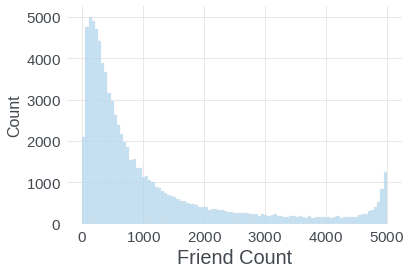

In [115]:
sns.histplot(df['friend_count2'], color ='#AED6F1' )
plt.xlabel("Friend Count",fontsize = 20)
plt.ylabel("Count", fontsize = 16)
plt.show()

In [14]:
print("Avg. Friend Count: ", df['friend_count2'].mean())

Avg. Friend Count:  1116.297373193705


In [826]:
len(df[df['friend_count2']>=3500])/len(df)

0.08942842099104897

### Friend count vs. Friend count satisfaction

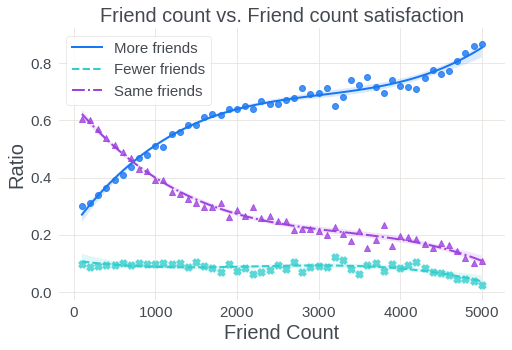

In [16]:
df_bin = df.groupby('friend_bins').apply(lambda x: Counter(x['satisfaction'])).reset_index()
df_bin = df_bin.merge(df.groupby('friend_bins')['rid'].count().reset_index().rename(columns = {'rid':'bin_sum'}), on = 'friend_bins')

g1 = []
g4 = []
g7 = []
for bin in sorted(df['friend_bins'].unique()):
    dfi = df_bin[df_bin['friend_bins']==bin]
    g1.append(dfi[0].iloc[0][-1]/dfi['bin_sum'])
    g4.append(dfi[0].iloc[0][0]/dfi['bin_sum'])
    g7.append(dfi[0].iloc[0][1]/dfi['bin_sum'])
    
plt.figure(figsize= (8,5))
sns.regplot(x=np.linspace(0, 5000, 51)[1:], y = g7, marker = 'o',line_kws = {'lw':2},order =3, label = '1')
sns.regplot(x=np.linspace(0, 5000, 51)[1:], y = g1, marker = 'x', line_kws={'lw':2, 'ls':'--'}, order =3,label = '-1')
sns.regplot(x=np.linspace(0, 5000, 51)[1:], y = g4, marker = '^',line_kws = {'lw':2, 'ls':'-.'}, order = 3, label = '0')

plt.xlabel("Friend Count", fontsize = 20)
plt.ylabel('Ratio', fontsize = 20)
plt.title("Friend count vs. Friend count satisfaction",fontsize = 20)
plt.legend(labels = ['More friends', 'Fewer friends','Same friends'],fontsize = 15)
#plt.savefig('./notebooks/image/satisfaction_trend.pdf', facecolor = '1', bbox_inches = 'tight')
plt.show()

### (Section 3.1) Friendship Paradox

In [57]:
df['is_paradox'] = df.apply(lambda x: 1 if x['avg_friend_friend']>x['friend_count2'] else 0, axis = 1)

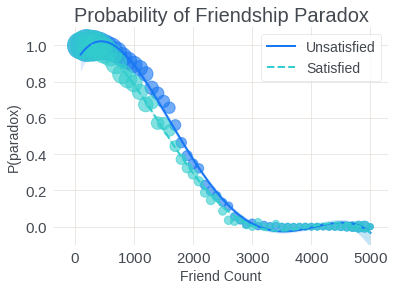

In [132]:
f='is_paradox'
sns.regplot(x=np.linspace(0, 5000, 51)[1:],y =df[df['satisfaction']!=0].groupby('friend_bins')[f].mean(), order = 4, line_kws={'lw':2},  scatter_kws = {'s': df.groupby('friend_bins')[f].count()/10 +15, 'alpha':0.6},label = 'unsatisfied')
sns.regplot(x=np.linspace(0, 5000, 51)[1:],y =df[df['satisfaction']==0].groupby('friend_bins')[f].mean(), order = 4, line_kws={'lw':2, 'ls':'--'},  scatter_kws = {'s': df.groupby('friend_bins')[f].count()/10 +15, 'alpha':0.6},label = 'satisfied')
plt.xlabel('Friend Count', fontsize = 14)
plt.ylabel('P(paradox)', fontsize = 14)
plt.title("Probability of Friendship Paradox", fontsize = 20)
plt.ylim((-0.1,1.1))
plt.legend(['Unsatisfied','Satisfied'],fontsize = 14)
#plt.savefig('./image/p_paradox_group.pdf', facecolor = '1', bbox_inches = 'tight')
plt.show()

### (Section 3.2) Local Perception Bias

In [16]:
df = df.merge(df.groupby('friend_bins2')['avg_friend_friend'].mean().reset_index().rename(columns = {'avg_friend_friend':'global_friend'}), on = 'friend_bins2')
df['bias_friend'] = df['avg_friend_friend'] - df['global_friend']

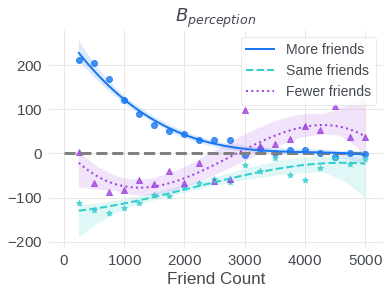

In [78]:
sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] == 1].groupby('friend_bins2').mean()['bias_friend'], order = 3, line_kws={'lw':2}, label = 'more friends')
sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] == 0].groupby('friend_bins2').mean()['bias_friend'], order = 3, line_kws={'lw':2, 'ls':'--'}, marker='*', label = 'same friends')
sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] ==-1].groupby('friend_bins2').mean()['bias_friend'], order = 3, line_kws={'lw':2, 'ls':':'}, marker='^', label = 'less friends')
plt.hlines(y = 0, xmin = 0, xmax = 5000, linewidth = 3, color = 'gray', linestyle = 'dashed')
plt.xlabel('Friend Count', fontsize = 17)
plt.ylabel('')
plt.title("$B_{perception}$", fontsize = 18)
plt.legend(['More friends','Same friends','Fewer friends'], fontsize = 14)
#plt.savefig('./notebooks/image/observation_bias_all.pdf', facecolor = '1', bbox_inches = 'tight')
plt.show()

### (Section 3.3) Behavioral Diversity

In [29]:
df['ob_bias_bins'] =  pd.qcut(df['bias_friend'], q = 50)
df = df.merge(df.groupby('ob_bias_bins')['rid'].count().reset_index().rename(columns = {'rid':'ob_bias_bin_sum'}), on = 'ob_bias_bins')

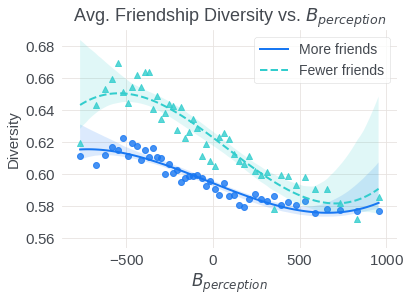

In [31]:
x = [i.left for i in sorted(df['ob_bias_bins'].unique())]
sns.regplot(x=x[1:-1], y =df[df['satisfaction'] == 1].groupby('ob_bias_bins').mean()['avg_friend_diversity'][1:-1], order = 3, line_kws={'lw':2}, label = 'more friends')
sns.regplot(x=x[1:-1], y =df[df['satisfaction'] ==-1].groupby('ob_bias_bins').mean()['avg_friend_diversity'][1:-1], order = 3, line_kws={'lw':2, 'ls':'--'}, marker='^', label = 'less friends')

plt.xlabel('$B_{perception}$', fontsize = 17)
plt.ylabel('Diversity')
plt.title("Avg. Friendship Diversity vs. $B_{perception}$", fontsize = 18)
plt.legend(['More friends','Fewer friends'], fontsize = 14)
#plt.savefig('./notebooks/image/diversity_b_observation.pdf', facecolor = '1', bbox_inches = 'tight')
plt.show()

In [776]:
print(df[df['satisfaction'] == 1].groupby('ob_bias_bins').mean()['avg_friend_diversity'].mean())
print(df[df['satisfaction'] == -1].groupby('ob_bias_bins').mean()['avg_friend_diversity'].mean())
mannwhitneyu(df[df['satisfaction'] == 1].groupby('ob_bias_bins').mean()['avg_friend_diversity'],df[df['satisfaction'] == -1].groupby('ob_bias_bins').mean()['avg_friend_diversity'])

0.5961930411377991
0.6231598414352285


MannwhitneyuResult(statistic=477.0, pvalue=5.034454598101387e-08)

### (Section 3.4) Friend Interactions

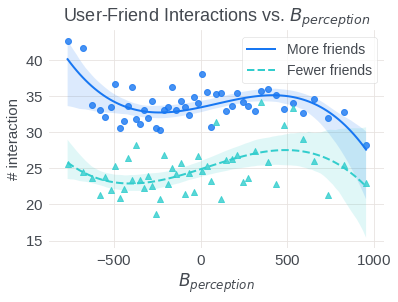

In [36]:
x = [i.left for i in sorted(df['ob_bias_bins'].unique())]
sns.regplot(x=x[1:-1], y =df[df['satisfaction'] == 1].groupby('ob_bias_bins').mean()['avg_friend_interact_count'][1:-1], order = 3, line_kws={'lw':2}, label = 'more friends')
sns.regplot(x=x[1:-1], y =df[df['satisfaction'] == -1].groupby('ob_bias_bins').mean()['avg_friend_interact_count'][1:-1], order = 3, line_kws={'lw':2, 'ls':'--'}, marker='^', label = 'less friends')

plt.xlabel('$B_{perception}$', fontsize = 17)
plt.ylabel('# interaction')
plt.title("User-Friend Interactions vs. $B_{perception}$", fontsize = 18)
plt.legend(['More friends','Fewer friends'], fontsize = 14)
#plt.savefig('./notebooks/image/interaction_b_observation.pdf', facecolor = '1', bbox_inches = 'tight')
plt.show()

In [286]:
print(df[df['satisfaction'] == 1].groupby('ob_bias_bins').mean()['avg_friend_interact_count'].mean())
print(df[df['satisfaction'] == -1].groupby('ob_bias_bins').mean()['avg_friend_interact_count'].mean())
mannwhitneyu(df[df['satisfaction'] == 1].groupby('ob_bias_bins').mean()['avg_friend_interact_count'],df[df['satisfaction'] == -1].groupby('ob_bias_bins').mean()['avg_friend_interact_count'])

34.033162334077765
24.915741242205137


MannwhitneyuResult(statistic=137.0, pvalue=8.641848387134526e-15)

### (Section 3.5) Weighted Perception Bias

In [18]:
## normalize interaction count
df['norm_interact'] = df['friend_interaction_count'].apply(lambda x: x if np.sum(x) == 0 else x/np.sum(x))

In [19]:
d_interact_exp = []
for i in tqdm(range(len(df))):
    dfi = df.iloc[i]
    cnt = dfi['friend_count2']
    d_interact_exp.append([np.exp(j) for j in dfi['norm_interact']])
df['d_interact'] = d_interact_exp

100%|██████████| 85465/85465 [01:49<00:00, 780.28it/s]


In [20]:
df['w_friend_count'] = df.apply(lambda x: np.dot(np.multiply(x['user_friend_diversity'], x['d_interact']), x['friend_friend_count'])/np.sum(np.multiply(x['user_friend_diversity'],x['d_interact'])), axis = 1)

In [22]:
df = df.merge(df.groupby('friend_bins2')['w_friend_count'].mean().reset_index().rename(columns = {'w_friend_count':'global_w_friend'}), on = 'friend_bins2')
df['bias_perception'] = df['w_friend_count'] - df['global_w_friend']

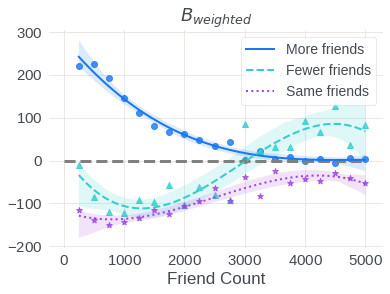

In [24]:
sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] == 1].groupby('friend_bins2').mean()['bias_perception'], order = 3, line_kws={'lw':2}, label = 'more friends')
sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] ==-1].groupby('friend_bins2').mean()['bias_perception'], order = 3, line_kws={'lw':2, 'ls':'--'}, marker='^', label = 'less friends')
sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] == 0].groupby('friend_bins2').mean()['bias_perception'], order = 3, line_kws={'lw':2, 'ls':':'}, marker='*', label = 'same friends')

plt.hlines(y = 0, xmin = 0, xmax = 5000, linewidth = 3, color = 'gray', linestyle = 'dashed')
plt.xlabel('Friend Count', fontsize = 17)
plt.ylabel('')
plt.title("$B_{weighted}$", fontsize = 18)
plt.legend(['More friends','Fewer friends','Same friends'], fontsize = 14)
#plt.savefig('./notebooks/image/perception_bias_all_new', facecolor = '1', bbox_inches = 'tight')
plt.show()

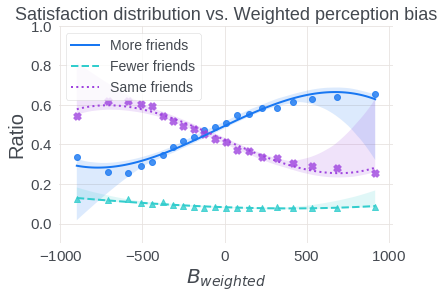

In [27]:
g1 = []
g4 = []
g7 = []
x = []
for bin in sorted(df["per_bias_bins"].unique()):
    dfi = df_bin[df_bin["per_bias_bins"] == bin]
    x.append(bin.left)
    g1.append(dfi[0].iloc[0][-1] / dfi["per_bias_bin_sum"])
    g4.append(dfi[0].iloc[0][0] / dfi["per_bias_bin_sum"])
    g7.append(dfi[0].iloc[0][1] / dfi["per_bias_bin_sum"])

x[0] = -900
#plt.figure(figsize= (8,5))
sns.regplot(x=x, y=g7, marker="o", line_kws={"lw": 2, "ls": "-"}, order=3, label="1")
sns.regplot(x=x, y=g1, marker="^", line_kws={"lw": 2, "ls": "--"}, order=3, label="-1")
sns.regplot(x=x, y=g4, marker="x", line_kws={"lw": 2, "ls": ":"}, order=3, label="0")
plt.xlabel("$B_{weighted}$", fontsize=20)
plt.ylabel("Ratio", fontsize=20)
plt.title("Satisfaction distribution vs. Weighted perception bias", fontsize=18)
plt.legend(labels=["More friends", "Fewer friends", "Same friends"], fontsize=14)
# plt.xlim((-1000,1000))
plt.ylim((-0.1, 1))

#plt.savefig('./notebooks/image/ratio_bias.pdf', facecolor = '1', bbox_inches = 'tight')
plt.show()


### (Section 3.5.2) Weighted perception bias vs. original perception bias

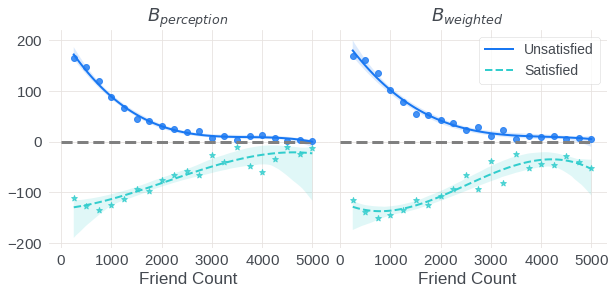

In [883]:
fig, axes = plt.subplots(1,2, figsize = (10,4), sharey = True)
fig.subplots_adjust(wspace = 0)

sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] != 0].groupby('friend_bins2').mean()['bias_friend'], order = 3, line_kws={'lw':2}, label = 'unsatisfied', ax = axes[0])
sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] == 0].groupby('friend_bins2').mean()['bias_friend'], order = 3, line_kws={'lw':2, 'ls':'--'}, marker='*', label = 'satisfied', ax = axes[0])
axes[0].hlines(y = 0, xmin = 0, xmax = 5000, linewidth = 3, color = 'gray', linestyle = 'dashed')
axes[0].set_xlabel('Friend Count', fontsize = 17)
axes[0].set_ylabel('')
axes[0].set_title("$B_{perception}$", fontsize = 18)

sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] != 0].groupby('friend_bins2').mean()['bias_perception'], order = 3, line_kws={'lw':2}, label = 'unsatisfied', ax = axes[1])
sns.regplot(x=np.linspace(0, 5000, 21)[1:], y =df[df['satisfaction'] == 0].groupby('friend_bins2').mean()['bias_perception'], order = 3, line_kws={'lw':2, 'ls':'--'}, marker='*', label = 'satisfied', ax = axes[1])
plt.hlines(y = 0, xmin = 0, xmax = 5000, linewidth = 3, color = 'gray', linestyle = 'dashed')
plt.xlabel('Friend Count', fontsize = 17)
plt.ylabel('')
axes[1].set_title("$B_{weighted}$", fontsize = 18)

plt.legend(['Unsatisfied', 'Satisfied'], fontsize = 14)
#plt.savefig('./notebooks/image/bias_comp.pdf', facecolor = '1', bbox_inches = 'tight')
plt.show()

In [25]:
df['per_bias_bins'] =  pd.qcut(df['bias_perception'], q =20)
df = df.merge(df.groupby('per_bias_bins')['rid'].count().reset_index().rename(columns = {'rid':'per_bias_bin_sum'}), on = 'per_bias_bins')

df_bin = df.groupby('per_bias_bins').apply(lambda x: Counter(x['satisfaction'])).reset_index()
df_bin = df_bin.merge(df.groupby('per_bias_bins')['rid'].count().reset_index().rename(columns = {'rid':'per_bias_bin_sum'}), on = 'per_bias_bins')

In [923]:
print(df[(df['satisfaction']==0) & (df['friend_count']>4000)]['bias_perception'].mean(), df[(df['satisfaction']!=0) & (df['friend_count']>4000)]['bias_perception'].mean())
print(mannwhitneyu(df[(df['satisfaction']==0) & (df['friend_count']>4000)]['bias_friend'],df[(df['satisfaction']!=0) & (df['friend_count']>4000)]['bias_friend']))

-29.333555127215867 5.259177071705844
MannwhitneyuResult(statistic=1817513.0, pvalue=0.08625267684461485)
Ttest_indResult(statistic=-2.2393912392653443, pvalue=0.025161046157145747)
-41.76205902524252 6.935437712253877
MannwhitneyuResult(statistic=3130830.0, pvalue=0.0024916694717829146)
Ttest_indResult(statistic=-3.148117664420026, pvalue=0.0016508758989582334)


## (Section 4) On-platform Behaviors

In [67]:
df['p_bias_group'] = df['bias_perception'].apply(lambda x: 1 if x>0 else 0)

### Motifs

In [45]:
good_pattern = '(like|love|wow|care|support|sorry)'
bad_pattern = '(anger|haha)'
positive_pattern = '(like|love|wow|care|support)'
negative_pattern = '(anger|sorry)'

motif_patterns = {
    "dyad_good": "^"+good_pattern+"\d->\w*$",
    "dyad_bad": "^"+bad_pattern+"\d->\w*$",
    "dyad_comment": "^\w*(comment)\w*\w*->\w*$",
    "sink_good": good_pattern+"\d->\w*<-"+good_pattern+"\d",
    "sink_bad": bad_pattern+"\d->\w*<-"+bad_pattern+"\d",
    "sink_mix": "("+bad_pattern+"\d->\w*<-"+good_pattern+"\d)|("+good_pattern+"\d->\w*<-"+bad_pattern+"\d)",
    "sink_good_comment": "(\w*(comment)\w*->\w*<-"+good_pattern+"\d)|("+good_pattern+"\d->\w*<-\w*(comment)\w*)",
    "sink_bad_comment":"(\w*(comment)\w*->\w*<-"+bad_pattern+"\d)|("+bad_pattern+"\d->\w*<-\w*(comment)\w*)",
    "sink_comment": "((reply)\w*->\w*<-(reply)\w*)",
    "path_good_comment": "(\w*(comment)\w*->\w*->"+good_pattern+"\d)|("+good_pattern+"\d->\w*->\w*(comment)\w*)",
    "path_bad_comment":  "(\w*(comment)\w*->\w*->"+bad_pattern+"\d)|("+bad_pattern+"\d->\w*->\w*(comment)\w*)",
    "path_comment": "(\w*(comment)\w*->\w*->\w*(comment)\w*)"
}

motif_features =pd.DataFrame(list(map(ast.literal_eval, map(str,df['motif_counts'][-df.motif_counts.isnull()])))).fillna(0)
motif_merge = motif_features.copy()
for k,v in motif_patterns.items():
    motif_merge.columns = motif_merge.columns.str.replace(v, k)
motif_merge = motif_merge.groupby(motif_merge.columns, axis = 1).sum()

In [46]:
deep_motifs = []
for k in ['dyad_comment','sink_comment','sink_good_comment','sink_bad_comment','path_bad_comment','path_good_comment','path_comment']:
    for f in motif_features.filter(regex = motif_patterns[k], axis =1).keys():
        if(len(set(re.findall(r'comment\d+', f))) > 1):
            deep_motifs.append(f)
df['deep_motif'] = motif_features[deep_motifs].sum(axis = 1)

In [47]:
pos_motifs = []
neg_motifs = []
for k in ['dyad_good', 'path_good_comment', 'sink_good', 'sink_good_comment']:
    for f in motif_features.filter(regex = motif_patterns[k], axis =1).keys():
        pos_motifs.append(f)
for k  in ['dyad_bad', 'path_bad_comment', 'sink_bad', 'sink_bad_comment']:
    for f in motif_features.filter(regex = motif_patterns[k], axis =1).keys():
        neg_motifs.append(f)
df['pos_motif'] = motif_features[pos_motifs].sum(axis = 1)
df['neg_motif'] = motif_features[neg_motifs].sum(axis = 1)

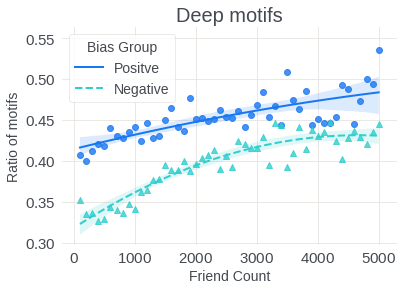

0.4324442271731558 0.35697027032766443
deep_motif MannwhitneyuResult(statistic=744232899.5, pvalue=0.0)


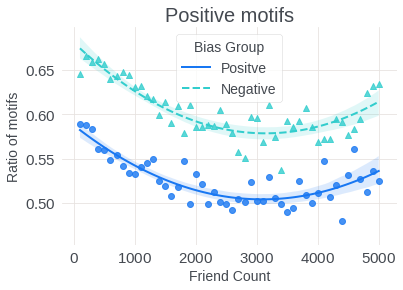

0.549815731826888 0.6376343800675509
pos_motifs MannwhitneyuResult(statistic=733040870.5, pvalue=0.0)


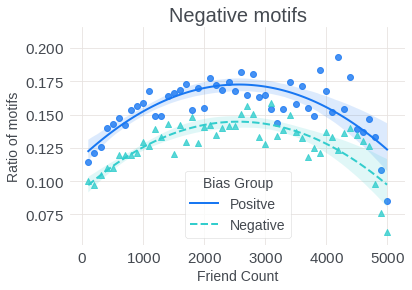

0.14436610141106693 0.11561590600645466
neg_motifs MannwhitneyuResult(statistic=866950809.5, pvalue=7.409847211439165e-28)


In [339]:
motif_features = ['deep_motif','pos_motifs','neg_motifs']
motif_names = ['Deep motifs','Positive motifs','Negative motifs']
for i in range(3):
    f = motif_features[i]
    motif_ratio_high = df[df['p_bias_group']==1].groupby('friend_bins')[f].mean()
    motif_ratio_low = df[df['p_bias_group']==0].groupby('friend_bins')[f].mean()
    ax = sns.regplot(x=np.linspace(0, 5000, 51)[1:],y = motif_ratio_high.values, order = 2, line_kws={'lw':2}, label = 'Positive')
    ax = sns.regplot(x=np.linspace(0, 5000, 51)[1:],y = motif_ratio_low.values, order = 2, line_kws={'lw':2, 'ls':'--'}, marker='^', label = 'less')
    plt.xlabel('Friend Count', fontsize = 14)
    plt.ylabel("Ratio of motifs", fontsize = 14)
    plt.title(motif_names[i],fontsize = 20)
    plt.legend(['Positve','Negative'], fontsize = 14, title_fontsize =14)
    ax.legend_.set_title("Bias Group")
    #plt.savefig('./notebooks/image/'+f+'_bias', facecolor = '1', bbox_inches = 'tight')
    plt.show()
    print(df[df['p_bias_group']==1][f].mean(), df[df['p_bias_group']==0][f].mean())
    print(f, mannwhitneyu(df[df['p_bias_group']==1][f], df[df['p_bias_group']==0][f]))

### User Activity

In [ ]:
df['give_cnt'] = df['comment_give']+df['like_give']
df['receive_cnt'] = df['comment_receive']+df['like_receive']

In [376]:
print(df[df['p_bias_group'] == 1]['post_cnt'].mean(),df[df['p_bias_group'] == 0]['post_cnt'].mean())
mannwhitneyu(df[df['p_bias_group'] == 1]['post_cnt'],df[df['p_bias_group'] == 0]['post_cnt'])

83.37076690030553 75.32352308882965


MannwhitneyuResult(statistic=891020007.5, pvalue=1.766156950673234e-05)

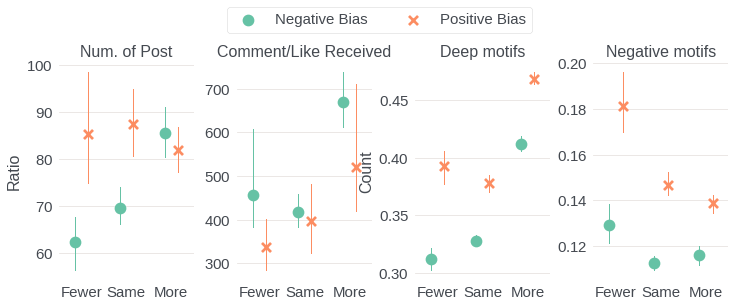

In [76]:
fnames = [ 'Num. of Post','Comment/Like Received',"Deep motifs", "Negative motifs"]
plot_features = ['post_cnt',  'receive_cnt','deep_motif','neg_motif']
fig, axes = plt.subplots(1,4, figsize = (12,4))
fig.subplots_adjust(wspace = 0.32)
for i in range(4):
    f = plot_features[i]
    sns.pointplot(data=df, x="satisfaction", y=f, hue="p_bias_group", err_style="bars" ,linestyle= '', markers= ['o','x'], scale =0.5, ci = 100, dodge = 0.3, linestyles='', errwidth = 1, palette="Set2", ax = axes[i])  # , showfliers=False)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')  
    axes[i].set_xticklabels(['Fewer','Same','More'],fontsize = 15)
    axes[i].legend([],[],frameon = False)
    axes[i].set_title(fnames[i],fontsize = 16)
    
axes[0].set_ylabel("Ratio",fontsize = 16)
axes[2].set_ylabel("Count",fontsize = 16)
axes[1].legend(bbox_to_anchor = (0.24,0.99,2,0.3), ncol = 2, fontsize = 15, title_fontsize = 14)
labels = ['Negative Bias','Positive Bias']
for j in range(2):
    axes[1].legend_.texts[j].set_text(labels[j])
#plt.savefig('./notebooks/image/bias_group.pdf', facecolor = '1', bbox_inches = 'tight')
plt.show()


## (Section 5) Prediction

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report, plot_roc_curve, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif

In [39]:
def pred_fold(X, y, y_name, fine_tune = True, balance = True, balance_type ='rus', selection = True):
    
    model_list=[]
    features_list = []
    f1_list = []
    roc_ovo = []
    roc_ovr = []
    for loop in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y, random_state = loop)

        if(selection == True):
            feature_list = []
            for i in range(10):
                train, val, y_t, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = i)
                kbest = SelectKBest(f_classif, k = max(X_train.shape[1]//10, 15)).fit(train, y_t)
                sel = list(X_train.columns[kbest.get_support()])
                feature_list+=sel
            f_dict = Counter(feature_list)
            select_features = [k for k,v in f_dict.items() if v==10]
            X_train = X_train[select_features]
        else:
            select_features = X_train.keys().tolist()

        df_train = pd.concat([X_train, y_train], axis = 1)          
        if(balance == True):
            if(balance_type =='ros'):
                bal_y = df_train[y_name].value_counts().index[df_train[y_name].value_counts().argmax()]
            else:
                bal_y = df_train[y_name].value_counts().index[df_train[y_name].value_counts().argmin()]

            dfs = []
            for i in y.unique():
                dfi = df_train[df_train[y_name] == i]
                if i == bal_y:
                    dfs.append(dfi)
                else:
                    dfs.append(resample(dfi, replace = True, n_samples = len(df_train[df_train[y_name] == bal_y]), random_state = 42))
            df_re = pd.concat(dfs, ignore_index = True)

            X_train = df_re.drop([y_name], axis = 1)
            y_train = df_re[y_name]


        if (fine_tune == True):
            max_depth = [5,10]
            max_depth.append(None)
            min_samples_leaf = [1,5]
            min_samples_split = [2,5]
            n_estimators = [100,200,500]

            max_features = ['auto', 0.25, 0.5, 0.75]

            random_grid = {'n_estimators': n_estimators,
                           'max_depth': max_depth,
                           'max_features':max_features,
                          'min_samples_leaf': min_samples_leaf,
                          'min_samples_split': min_samples_split,
                          'class_weight': ['balanced_subsample']}

            clf = RandomForestClassifier()

            model = RandomizedSearchCV(estimator = clf, n_iter = 50,
                                      param_distributions = random_grid,
                              cv = 5, verbose = 1, n_jobs = -1)
        else:
            model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 0.5, n_jobs = -1, random_state = 0)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test[select_features])


        if(fine_tune == True):
            model_list.append(model.best_estimator_)
            features_list.append(select_features)
        else:
            model_list.append(model)
            features_list.append(select_features)
        if(len(y.unique()) > 2):
            f1_list.append(f1_score(y_test, y_pred, average = 'weighted'))
            roc_ovo.append(roc_auc_score(y_test,  model.predict_proba(X_test[select_features]), multi_class = 'ovo'))
            roc_ovr.append(roc_auc_score(y_test,  model.predict_proba(X_test[select_features]),  multi_class = 'ovr'))
        else:
            f1_list.append(f1_score(y_test, y_pred, average = 'weighted'))
            roc_ovo.append(roc_auc_score(y_test,  model.predict_proba(X_test[select_features])[:, 1] ))
            roc_ovr.append(roc_auc_score(y_test,  model.predict_proba(X_test[select_features])[:, 1]))
        
    return model_list, features_list, f1_list, roc_ovo, roc_ovr

In [40]:
df_area = pd.get_dummies(df['business_region'])
df_gender = pd.get_dummies(df['gender_name'])

In [42]:
user_stats =['friend_count2']
demo_features = ['female', 'age'] + ['APAC','CA','CEE',	'EMEA','LATAM','US']
activity_features = ['days_since_confirmed','time_spent_28d_overall',  'post_cnt',  'comment_give', 'like_give', 'comment_receive', 'like_receive']
friend_stats=[ 'avg_post_cnt', 'avg_comment_receive', 'avg_like_receive','avg_comment_give', 'avg_like_give']

### (Section 3.5.2) Compare $B_{weight}$ and $B_{perception}$

Only consider diversity

In [ ]:
df['w_friend_count_div'] = df.apply(lambda x: np.dot(x['user_friend_diversity'], x['friend_friend_count'])/np.sum(x['user_friend_diversity']), axis = 1)
df = df.merge(df.groupby('friend_bins2')['w_friend_count_div'].mean().reset_index().rename(columns = {'w_friend_count_div':'global_w_friend_div'}), on = 'friend_bins2')
df['bias_perception_div'] = df['w_friend_count_div'] - df['global_w_friend_div']

Only consider interactions

In [ ]:
df['w_friend_count_int'] = df.apply(lambda x: np.dot(x['d_interact'], x['friend_friend_count'])/np.sum(x['d_interact']), axis = 1)
df = df.merge(df.groupby('friend_bins2')['w_friend_count_int'].mean().reset_index().rename(columns = {'w_friend_count_int':'global_w_friend_int'}), on = 'friend_bins2')
df['bias_perception_int'] = df['w_friend_count_int'] - df['global_w_friend_int']

In [50]:
df_feature = pd.concat([df[user_stats+activity_features + friend_stats+ ['friend_numeric','satisfaction','bias_friend','bias_perception','age','bias_perception_div','bias_perception_int']], df_area, df_gender], axis =1).replace([np.inf, -np.inf], np.nan).fillna(0)
df_feature[[ 'friend_count2','age']]= df_feature[[ 'friend_count2','age']].astype(int)

w/o bias

In [609]:
X = df_feature[user_stats + demo_features]
y = df_feature['satisfaction']
model_demo, select_features_demo, f1_list_demo, roc_ovo_demo, roc_ovr_demo = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_demo = pd.DataFrame([f1_list_demo, roc_ovo_demo, roc_ovr_demo], index = ['F1','ROC_ovo','ROC_ovr']).T
df_demo['model'] = 'demo'
df_demo.mean()

F1         0.584805
ROC_ovo    0.662760
ROC_ovr    0.687807
dtype: float64

w/ $B_{perception}$

In [748]:
X = df_feature[user_stats + demo_features+ ['bias_friend']]
y = df_feature['satisfaction']
model_demo_ob, select_features_demo_ob, f1_list_demo_ob, roc_ovo_demo_ob, roc_ovr_demo_ob = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_demo_ob = pd.DataFrame([f1_list_demo_ob, roc_ovo_demo_ob, roc_ovr_demo_ob], index = ['F1','ROC_ovo','ROC_ovr']).T
df_demo_ob['model'] = 'demo_ob'
df_demo_ob.mean()

F1         0.600524
ROC_ovo    0.671184
ROC_ovr    0.697963
dtype: float64

w/ $B_{weighted}$

In [751]:
X = df_feature[user_stats + demo_features+ ['bias_perception']]
y = df_feature['satisfaction']
model_demo_per, select_features_demo_per, f1_list_demo_per, roc_ovo_demo_per, roc_ovr_demo_per = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_demo_per = pd.DataFrame([f1_list_demo_per, roc_ovo_demo_per, roc_ovr_demo_per], index = ['F1','ROC_ovo','ROC_ovr']).T
df_demo_per['model'] = 'demo_per'
df_demo_per.mean()

F1         0.603111
ROC_ovo    0.673724
ROC_ovr    0.700700
dtype: float64

w/ $B_{weighted}$ diversity only

In [84]:
X = df_feature[user_stats + demo_features+ ['bias_perception_div']]
y = df_feature['satisfaction']
model_demo_perdiv, select_features_demo_perdiv, f1_list_demo_perdiv, roc_ovo_demo_perdiv, roc_ovr_demo_perdiv = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_demo_perdiv = pd.DataFrame([f1_list_demo_perdiv, roc_ovo_demo_perdiv, roc_ovr_demo_perdiv], index = ['F1','ROC_ovo','ROC_ovr']).T
df_demo_perdiv['model'] = 'demo_perdiv'
df_demo_perdiv.mean()

F1         0.603000
ROC_ovo    0.673655
ROC_ovr    0.700630
dtype: float64

w/ $B_{weighted}$ interaction only

In [85]:
X = df_feature[user_stats + demo_features+ ['bias_perception_int']]
y = df_feature['satisfaction']
model_demo_perint, select_features_demo_perint, f1_list_demo_perint, roc_ovo_demo_perint, roc_ovr_demo_perint = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_demo_perint = pd.DataFrame([f1_list_demo_perint, roc_ovo_demo_perint, roc_ovr_demo_perint], index = ['F1','ROC_ovo','ROC_ovr']).T
df_demo_perint['model'] = 'demo_perint'
df_demo_perint.mean()

F1         0.601607
ROC_ovo    0.673011
ROC_ovr    0.699898
dtype: float64

In [92]:
print("F1: ",  df_demo['F1'].mean(), df_demo_ob['F1'].mean(), df_demo_per['F1'].mean())
print("ROC_ovo: ",  df_demo['ROC_ovo'].mean(), df_demo_ob['ROC_ovo'].mean(), df_demo_per['ROC_ovo'].mean())
print("ROC_ovr: ",  df_demo['ROC_ovr'].mean(), df_demo_ob['ROC_ovr'].mean(), df_demo_per['ROC_ovr'].mean())

F1:  0.5848045193970886 0.600523689466854 0.6031109860088115
ROC_ovo:  0.6627599952206743 0.6711843015723672 0.6737240829573498
ROC_ovr:  0.6878073604372513 0.6979629122577187 0.7006998579121211


In [96]:
print("w/ ob_bias vs. per_basic: ",ttest_rel(df_demo_ob['F1'],df_demo['F1']))
print(ttest_rel(df_demo_per['F1'],df_demo['F1']))
print(ttest_rel(df_demo_per['F1'],df_demo_ob['F1']))
print("AUC_ROC ovo: ", ttest_rel(df_demo_ob['ROC_ovo'],df_demo['ROC_ovo']),ttest_rel(df_demo_per['ROC_ovo'],df_demo['ROC_ovo']),ttest_rel(df_demo_per['ROC_ovo'],df_demo_ob['ROC_ovo']), ttest_rel(df_demo_perdiv['ROC_ovo'],df_demo_ob['ROC_ovo']))
print("AUC_ROC ovr: ", ttest_rel(df_demo_ob['ROC_ovr'],df_demo['ROC_ovr']),ttest_rel(df_demo_per['ROC_ovr'],df_demo['ROC_ovr']),ttest_rel(df_demo_per['ROC_ovr'],df_demo_ob['ROC_ovr']),ttest_rel(df_demo_perdiv['ROC_ovo'],df_demo_ob['ROC_ovo']))

w/ ob_bias vs. per_basic:  Ttest_relResult(statistic=13.76464081337975, pvalue=2.3741497426457407e-07)
Ttest_relResult(statistic=19.765730093479192, pvalue=1.0073604281864169e-08)
Ttest_relResult(statistic=4.717171169228036, pvalue=0.0010934288210166763)
AUC_ROC ovo:  Ttest_relResult(statistic=21.267452316863512, pvalue=5.277421340819334e-09) Ttest_relResult(statistic=30.027458707149293, pvalue=2.4635206578493854e-10) Ttest_relResult(statistic=9.070999731319969, pvalue=8.006110677697534e-06) Ttest_relResult(statistic=9.37902596038118, pvalue=6.085099241488646e-06)
AUC_ROC ovr:  Ttest_relResult(statistic=28.912869537407172, pvalue=3.451620997621409e-10) Ttest_relResult(statistic=34.28801919921874, pvalue=7.534242797992774e-11) Ttest_relResult(statistic=9.598811510640797, pvalue=5.025984512762663e-06) Ttest_relResult(statistic=9.37902596038118, pvalue=6.085099241488646e-06)


### (Section 5.1 - Table 4) Comparing feature sets

In [54]:
user_stats =['friend_count2','is_paradox']
demo_features = ['female', 'age'] + ['APAC','CA','CEE',	'EMEA','LATAM','US']
activity_features = [ 'post_cnt',  'comment_give', 'like_give', 'comment_receive', 'like_receive']
friending_features = ['make_actor_28d','accept_actor_28d']
motif_features = ['deep_motif', 'pos_motif', 'neg_motif']

In [787]:
full_features = user_stats + demo_features + activity_features + friending_features + motif_features + ['bias_perception']

In [58]:
df_feature = pd.concat([df[user_stats+activity_features  + motif_features + ['friend_numeric','satisfaction','bias_perception','bias_friend','age']], df_area, df_gender], axis =1).replace([np.inf, -np.inf], np.nan).fillna(0)
df_feature[['friend_count2','age']]= df_feature[[ 'friend_count2','age']].astype(int)

#### friend count + demographic features

In [122]:
X = df_feature[user_stats + demo_features]
y = df_feature['satisfaction']
model_demo, select_features_demo, f1_list_demo, roc_ovo_demo, roc_ovr_demo = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_demo = pd.DataFrame([f1_list_demo, roc_ovo_demo, roc_ovr_demo], index = ['F1','ROC_ovo','ROC_ovr']).T
df_demo['model'] = 'demo'
df_demo.mean()

F1         0.585485
ROC_ovo    0.662927
ROC_ovr    0.687947
dtype: float64

In [131]:
X = df_feature[user_stats + demo_features+ ['bias_perception']]
y = df_feature['satisfaction']
model_demo_per, select_features_demo_per, f1_list_demo_per, roc_ovo_demo_per, roc_ovr_demo_per = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_demo_per = pd.DataFrame([f1_list_demo_per, roc_ovo_demo_per, roc_ovr_demo_per], index = ['F1','ROC_ovo','ROC_ovr']).T
df_demo_per['model'] = 'demo_per'
df_demo_per.mean()

F1         0.603806
ROC_ovo    0.673741
ROC_ovr    0.700806
dtype: float64

#### friend count + demographic features + activity

In [125]:
X = df_feature[user_stats + demo_features + activity_features]
y = df_feature['satisfaction']
model_act, select_features_act, f1_list_act, roc_ovo_act, roc_ovr_act = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_act = pd.DataFrame([f1_list_act, roc_ovo_act, roc_ovr_act], index = ['F1','ROC_ovo','ROC_ovr']).T
df_act['model'] = 'activity'
df_act.mean()

F1         0.586937
ROC_ovo    0.663457
ROC_ovr    0.688454
dtype: float64

#### friend count + demographic features + activity + motif

In [135]:
X = df_feature[user_stats + demo_features + activity_features + motif_features]
y = df_feature['satisfaction']
model_motif, select_features_motif, f1_list_motif, roc_ovo_motif, roc_ovr_motif = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_motif = pd.DataFrame([f1_list_motif, roc_ovo_motif, roc_ovr_motif], index = ['F1','ROC_ovo','ROC_ovr']).T
df_motif['model'] = 'motif'
df_motif.mean()

F1         0.587652
ROC_ovo    0.673064
ROC_ovr    0.697947
dtype: float64

#### full model

In [60]:
## without friending features
X = df_feature[user_stats + demo_features + activity_features + motif_features + ['bias_perception']]
y = df_feature['satisfaction']
model_full, select_features_full, f1_list_full, roc_ovo_full, roc_ovr_full = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_full = pd.DataFrame([ f1_list_full, roc_ovo_full, roc_ovr_full], index = ['F1','ROC_ovo','ROC_ovr']).T
df_full['model'] = 'full'
df_full.mean()

F1         0.605684
ROC_ovo    0.680434
ROC_ovr    0.707158
dtype: float64

In [142]:
X = df_feature[user_stats + demo_features + activity_features + motif_features + ['bias_friend']]
y = df_feature['satisfaction']
model_full_ob, select_features_full_ob, f1_list_full_ob, roc_ovo_full_ob, roc_ovr_full_ob = pred_fold(X, y, "satisfaction", fine_tune = False, balance = True, selection = False)
df_full_ob = pd.DataFrame([ f1_list_full_ob, roc_ovo_full_ob, roc_ovr_full_ob], index = ['F1','ROC_ovo','ROC_ovr']).T
df_full_ob['model'] = 'full_ob'
df_full_ob.mean()

F1         0.604923
ROC_ovo    0.680027
ROC_ovr    0.706663
dtype: float64

## (Section 5.2) Behavior Interactions

In [61]:
import shap

In [62]:
X = df_feature[user_stats + demo_features + activity_features + motif_features + ['bias_perception']]

m = model_full[0]
select_features = select_features_full[0]

In [64]:
samples = X[select_features]
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(X, approximate=False, check_additivity=False)

In [840]:
X = X.rename({'friend_count2':'friend_count', 'make_actor_28d':'friend request sent', 'accept_actor_28d':'friend request accepted', 'is_paradox': "has friendship paradox", 'bias_perception':'$B_{weighted}$'}, axis = 1)


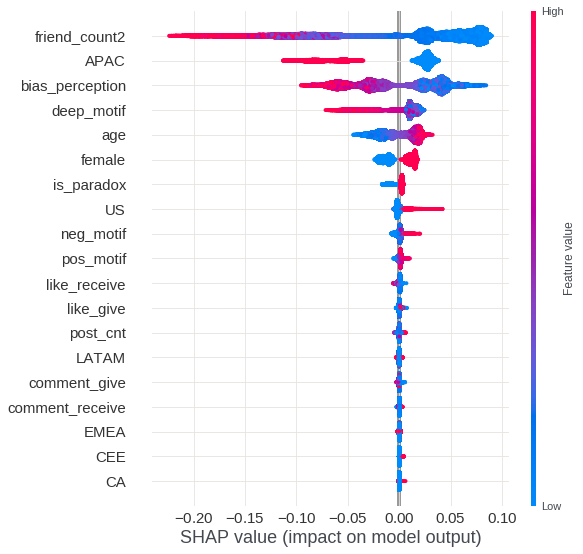

In [66]:
shap.summary_plot(shap_values[1], X, max_display = X.shape[1], show = False)
plt.xlabel("SHAP value (impact on model output)", fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('./notebooks/image/shap.pdf', facecolor = '1', bbox_inches = 'tight')

plt.show()

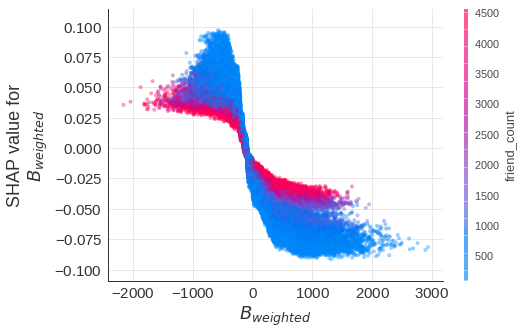

In [849]:
shap.dependence_plot('$B_{weighted}$', shap_values[1], X ,interaction_index = 'friend_count' , alpha = 0.4, show = False)
plt.ylabel("SHAP value for\n$B_{weighted}$", fontsize = 18)
plt.xlabel("$B_{weighted}$",fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('./notebooks/image/shap_bias.pdf', facecolor = '1', bbox_inches = 'tight')

plt.show()

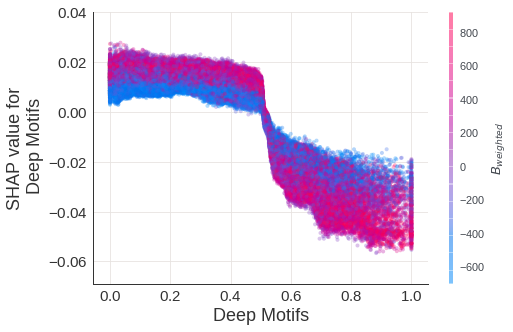

In [847]:
shap.dependence_plot('deep_motif', shap_values[1], X , interaction_index = '$B_{weighted}$', alpha = 0.3, show = False)
plt.ylabel("SHAP value for\n Deep Motifs", fontsize = 18)
plt.xlabel("Deep Motifs",fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('./notebooks/image/shap_bias_motif.pdf', facecolor = '1', bbox_inches = 'tight')
plt.show()